In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm

In [2]:
def get_ensemble(name,data_vars,htape,keys,paramkey,p=True):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/oleson/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=p,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0' or htape=='h1':
        ds['time'] = xr.cftime_range(str(2005),periods=len(ds.time),freq='MS') #fix time bug

    #specify extra variables    
    if htape=='h1':
        extras     = ['pfts1d_lat','pfts1d_lon','pfts1d_wtgcell','pfts1d_itype_veg']
    else:
        extras     = ['grid1d_lat','grid1d_lon']
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax/biome
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    whit         = xr.open_dataset('./whit/whitkey.nc')
    ds['biome']      = whit['biome']
    ds['biome_name'] = whit['biome_name']
    
    return ds


In [3]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [4]:
def get_cfs():
    df = pd.read_csv('agg_units.csv')
    cfs   = dict()
    units = dict()
    for i,row in df.iterrows():
        f = row['field']
        u = row['unit']
        c = row['cf']

        if c != 'intrinsic':
            c = float(c)
            
        cfs[f]   = c
        units[f] = u
    return cfs,units

In [5]:
def find_pair(da,params,minmax,p):
    '''
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])
    
def top_n(da,nx,params,minmax,uniques):
    xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(da,params,minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    return xmins,xmaxs,pvals

def plot20(da,nx,tstr,ll=True,xstr=''):
    
    uniques = list(np.unique(ds.param))
    uniques.remove('default')
    
    xmins,xmaxs,pvals = top_n(da,nx,params,minmax,uniques)
    xdef = da.isel(ens=0)
    unit = da.attrs['units']
    

    
    if len(xstr)==0:
        xstr=tstr
    nx = len(pvals)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    if ll:
        plt.legend(loc=3)
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    plt.title(tstr)
    plt.xlabel(xstr+' ('+unit+')');

In [6]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord].values))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord].values))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    ds = xr.open_dataset('/glade/scratch/oleson/PPEn11/hist/CTL2010SP/PPEn11_CTL2010SP_OAAT0399.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [7]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

In [8]:
# Setup your PBSCluster
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/work/oleson/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38297 instead
  f"Port {expected} is already in use.\n"


In [12]:
client

<Client: 'tcp://10.12.206.46:33132' processes=20 threads=20, memory=465.60 GiB>

## START HERE

### load ensemble

In [13]:
#fetch the paraminfo
csv = '/glade/u/home/oleson/ppe_tools/jobscripts/PPEn11/SP_ensemble.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

#fetch unit/cf dicts
cfs,units = get_cfs()

In [14]:
env = 'CTL2010SP'
keys = paramkey.key
data_vars = ['FPSN','TWS','EFLX_LH_TOT','FCTR',
             'FCEV','FGEV','QHR',
             'QOVER','QDRAI','SOILWATER_10CM','SNOWDP','TV','TSOI_10CM','TLAI','FSR','FSH']
ds = get_ensemble(env,data_vars,'h0',keys,paramkey)
params = ds.param
minmax = ds.minmax
ds.FPSN

<xarray.DataArray 'FPSN' (ens: 231, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(231, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 223 224 225 226 227 228 229 230
  * time      (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Attributes:
    long_name:     photosynthesis
    units:         umol m-2 s-1
    cell_methods:  time: mean

### global annual avg / iav

In [15]:
def calc_mean(ds,datavar,la,dim='gridcell'):

    domain='glob'
    preload = './data/'+env+'_'+datavar+'_'+domain+'.nc'
    
    if not glob.glob(preload):
        #do the calculation
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            cf = 1/la.sum()/365
        x  = ds[datavar]

        #calc annual mean or sum (determined by cf)
        if datavar=='ALTMAX':
            ## unique logic for ALTMAX
            ix   = ds.ALTMAX.isel(ens=0).mean(dim='time')<10
            xann = cf*(la*ds.ALTMAX.where(ix).groupby('time.year').max()).sum(dim=dim).compute()
        else:
            xann = cf*(month_wts(10)*(la*x).sum(dim=dim)).groupby('time.year').sum().compute()

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')
        
        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = ds.param
        out['minmax'] = ds.minmax
        out.load().to_netcdf(preload)
    

    #load from file if available
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav

### GPP

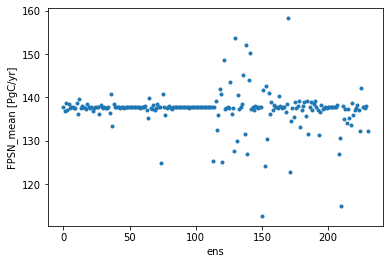

In [16]:
datavar = 'FPSN'
gpp,iav = calc_mean(ds,datavar,la,dim='gridcell')
gpp.plot.line('.');

In [17]:
#which perturbations yield the bottom 10 lowest GPP?
print('LOW GPP:')
for i in np.argsort(gpp)[:10]:
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print('   '+p+'-'+m)

LOW GPP:
   kmax-min
   medlynintercept-max
   leafcn-max
   krmax-min
   fff-min
   theta_cj-min
   medlynslope-max
   jmaxb1-min
   jmaxb0-min
   act25-min


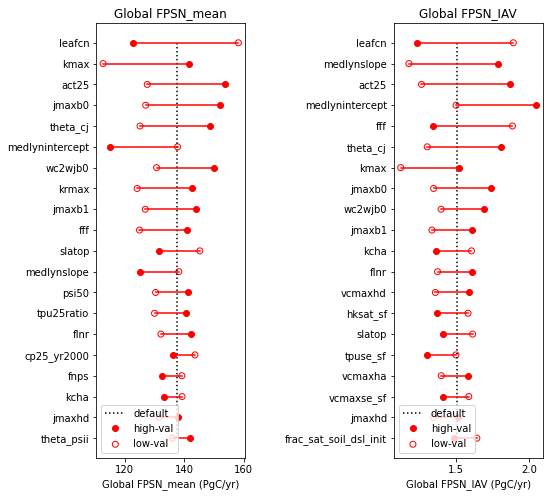

In [18]:
datavar = 'FPSN'
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(gpp,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

### SNOWDP

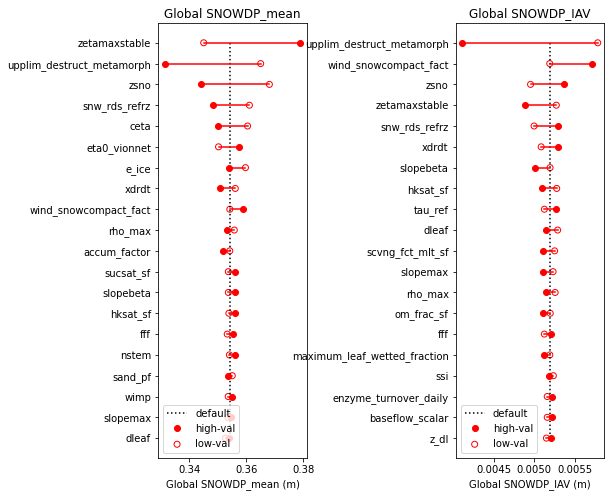

In [19]:
datavar = 'SNOWDP'
da,iav = calc_mean(ds,datavar,la,dim='gridcell')
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(da,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

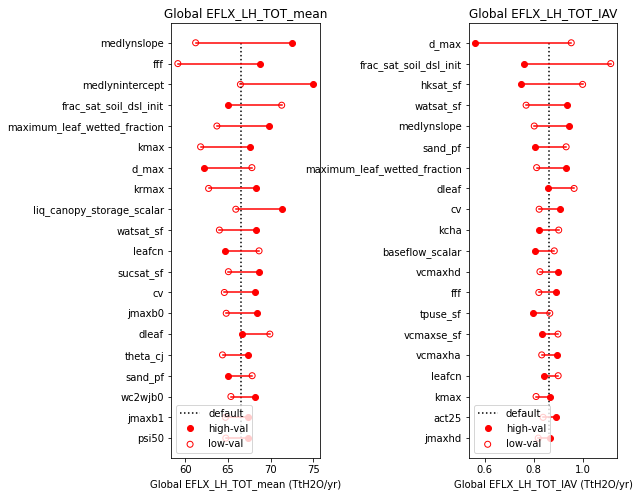

In [20]:
datavar = 'EFLX_LH_TOT'
da,iav = calc_mean(ds,datavar,la,dim='gridcell')
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(da,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

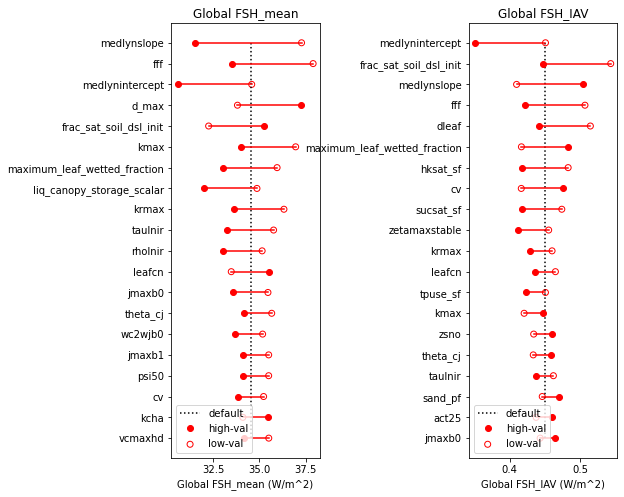

In [21]:
datavar = 'FSH'
da,iav = calc_mean(ds,datavar,la,dim='gridcell')
plt.figure(figsize=[8,8])
plt.subplot(121)
plot20(da,20,'Global ' + datavar + '_mean')
plt.subplot(122)
plot20(iav,20,'Global ' + datavar + '_IAV')
plt.subplots_adjust(wspace=1.0)

In [22]:
def calc_mean_biome(dsb,datavar,lab):

    domain='biome'
    preload = './data/'+env+'_'+datavar+'_'+domain+'.nc'
    
    if not glob.glob(preload):
        #do the calculation
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            cf = 1/lab.groupby('biome').sum()/365
        x  = dsb[datavar]

        #calc annual mean or sum (determined by cf)
        xann = cf*(month_wts(10)*(lab*x).groupby('biome').sum()).groupby('time.year').sum().compute()

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')
        
        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = dsb.param
        out['minmax'] = dsb.minmax
        out.load().to_netcdf(preload)
    

    #load from file if available
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav

In [23]:
la['biome']=ds['biome']
lab = la.swap_dims({'gridcell':'biome'})
dsb = ds.swap_dims({'gridcell':'biome'})

In [24]:
datavar = 'SOILWATER_10CM'
da,iav = calc_mean_biome(dsb,datavar,lab)

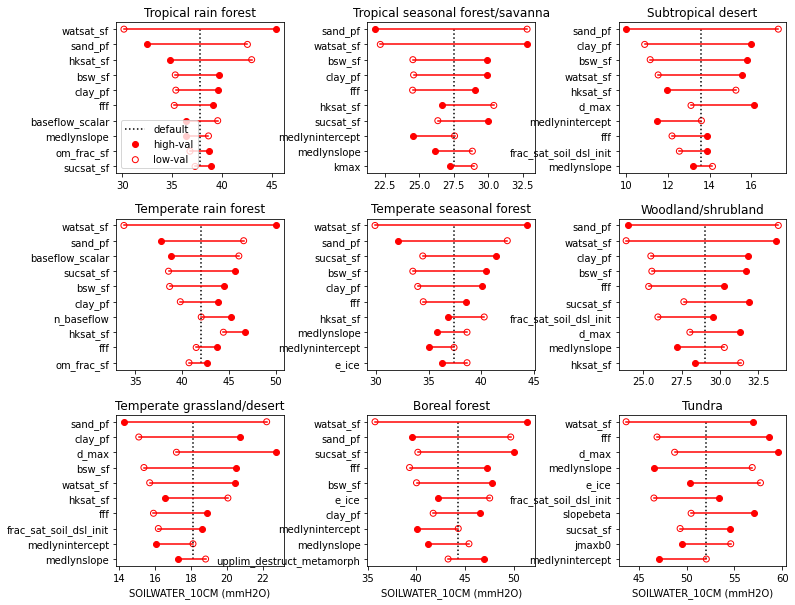

In [25]:
### exclude ice sheet
plt.figure(figsize=[12,10])
ll=True
for i in 1+np.arange(9):
    plt.subplot(3,3,i)
    
    b = str(dsb.biome_name.isel(biome_id=i).values)
    
    plot20(da.isel(biome=i),10,b,ll=ll,xstr=datavar)
    ll=False
    if i<7:
        plt.xlabel('')
        
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.5)

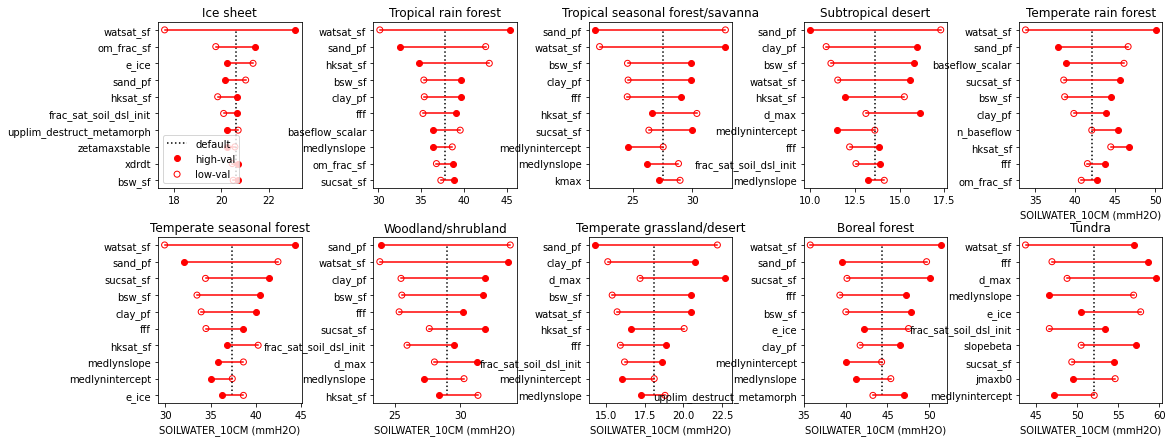

In [26]:
### include ice sheet
plt.figure(figsize=[18,7])
ll=True
for i in range(10):
    plt.subplot(2,5,i+1)
    
    b = str(dsb.biome_name.isel(biome_id=i).values)
    
    plot20(da.isel(biome=i),10,b,ll=ll,xstr=datavar)
    ll=False
    if i<4:
        plt.xlabel('')
        
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.5)

In [27]:
#fetch the paraminfo
csv = '/glade/u/home/oleson/ppe_tools/jobscripts/PPEn11/SP_ensemble.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

#fetch unit/cf dicts
cfs,units = get_cfs()

In [28]:
env = 'CTL2010SP'
keys = paramkey.key
data_vars = ['SOILWATER_10CM','FPSN','EFLX_LH_TOT','TWS']
ds = get_ensemble(env,data_vars,'h4',keys,paramkey)
params = ds.param
minmax = ds.minmax

In [29]:
ix = np.arange(3651)>0
sw = 1/la.sum()*(la*ds.SOILWATER_10CM.isel(time=ix).std(dim='time')).sum(dim='gridcell').compute()
sw.attrs={'units':'mmH2O'}

/glade/work/oleson/miniconda3/envs/ppe-py/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


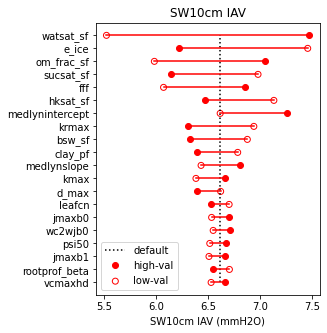

In [30]:
plt.figure(figsize=[4,5])
plot20(sw,20,'SW10cm IAV')